## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf

from PIL import Image

import os
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2

import

np.random.seed(1)

## Reading the training data from train.csv file

In [2]:
train = pd.read_csv("train_labels_.csv")

In [3]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [4]:
train.shape

(173, 8)

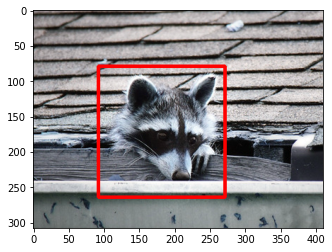

In [6]:
row = train.sample()

img = cv2.imread(f'images/{row.filename.values[0]}')
xmin = row.xmin.values[0]
ymin = row.ymin.values[0]
xmax = row.xmax.values[0]
ymax = row.ymax.values[0]

img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=4)
plt.imshow(img)
plt.show()


* Create a list variable known as 'path' which has all the path for all the training images
* Create an array 'coords' which has the resized coordinates of the bounding box for the training images

In [7]:
IMAGE_SIZE = 128

In [8]:
coords = train[["width","height","xmin","ymin","xmax","ymax"]]

coords["xmin"] = coords["xmin"] * IMAGE_SIZE / coords["width"]
coords["xmax"] = coords["xmax"] * IMAGE_SIZE / coords["width"]
coords["ymin"] = coords["ymin"] * IMAGE_SIZE / coords["height"]
coords["ymax"] = coords["ymax"] * IMAGE_SIZE / coords["height"]

coords.drop(["width","height"], axis=1, inplace=True)
coords.head()

C:\Users\fitz1\AppData\Local\Temp\ipykernel_11800\2808846927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords["xmin"] = coords["xmin"] * IMAGE_SIZE / coords["width"]
C:\Users\fitz1\AppData\Local\Temp\ipykernel_11800\2808846927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords["xmax"] = coords["xmax"] * IMAGE_SIZE / coords["width"]
C:\Users\fitz1\AppData\Local\Temp\ipykernel_11800\2808846927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,xmin,ymin,xmax,ymax
0,46.949807,39.587629,82.532819,77.855670
1,0.581818,0.296296,89.406061,127.703704
2,15.786667,34.240000,59.733333,92.800000
3,48.426667,29.760000,85.973333,95.360000
4,27.194139,22.832432,92.366300,87.870270


In [38]:
paths = train["filename"]
len(paths)

173

In [39]:
images = "../input/racoon-detection/Racoon Images/images/"

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

for i, f in enumerate(paths):
    img = Image.open(images + f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

## Model Building
* Building the model using transfer learning

In [40]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [41]:
for layers in model.layers:
    layers.trainable = False

x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x)

model = Model(inputs=model.inputs, outputs=x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

## Define a custom loss function IoU which calculates Intersection Over Union

In [77]:
def loss(gt, pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use 1e-8 to prevent division by zero
    iou = np.round(intersections / (unions + 1e-8), 4)
    iou = iou.astype(np.float32)
    return iou


def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

## Compiling the model

In [78]:
gt = coords

PATIENCE=10

model.compile(optimizer="Adam",
              loss="mse",
              metrics=[IoU])

stop = EarlyStopping(monitor='val_iou', patience=PATIENCE, mode="max")

reduce_lr = ReduceLROnPlateau(monitor='val_iou', factor=0.2, patience=PATIENCE,
                              min_lr=1e-7, verbose=1, mode="max")

model.fit(batch_images, gt,
          epochs=100,
          callbacks=[stop, reduce_lr],
          verbose=1)

Epoch 1/100
6/6 [==============================] - 0s 61ms/step - loss: 88.7390 - IoU: 0.7811
Epoch 2/100
6/6 [==============================] - 0s 83ms/step - loss: 62.4774 - IoU: 0.8313
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 58.1653 - IoU: 0.8439
Epoch 4/100
6/6 [==============================] - 0s 68ms/step - loss: 56.3654 - IoU: 0.8376
Epoch 5/100
6/6 [==============================] - 0s 56ms/step - loss: 53.1075 - IoU: 0.8555
Epoch 6/100
6/6 [==============================] - 0s 57ms/step - loss: 53.8911 - IoU: 0.8608
Epoch 7/100
6/6 [==============================] - 0s 56ms/step - loss: 52.0919 - IoU: 0.8698
Epoch 8/100
6/6 [==============================] - 0s 56ms/step - loss: 52.3682 - IoU: 0.8764
Epoch 9/100
6/6 [==============================] - 0s 59ms/step - loss: 52.9515 - IoU: 0.8743
Epoch 10/100
6/6 [==============================] - 0s 59ms/step - loss: 52.0381 - IoU: 0.8830
Epoch 11/100
6/6 [==============================] - 0s 58m

## Pick a test image from the given data

In [112]:
test_img = random.choice(paths)
filename = images + test_img
unscaled = cv2.imread(filename)
unscaled = cv2.cvtColor(unscaled, cv2.COLOR_BGR2RGB)

## Preprocessing of Test Image
Resizing the image to 128 * 128 and preprocess the image for the MobileNet model

In [113]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

* Predict the coordinates of the bounding box for the given test image

In [114]:
region = model.predict(x=np.array([feat_scaled]))[0]

* Scaling the BBox

In [115]:
x0 = int(region[0] * image_width / IMAGE_SIZE) 
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

## Plotting the predicted bounding box

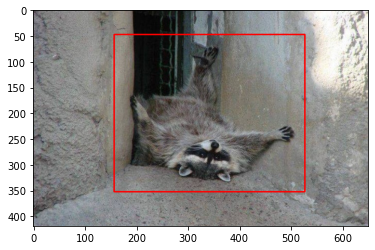

In [116]:
unscaled = cv2.rectangle(unscaled, (x0, y0), (x1, y1), color=(255, 0, 0), thickness=2)

# Display the image
plt.imshow(unscaled)
plt.show()